In [1]:
import pandas as pd
import numpy as np

In [2]:
def load_dataset():
    train_df = pd.read_csv("../Data/UNSW_NB15_testing-set.csv")
    test_df = pd.read_csv("../Data/UNSW_NB15_training-set.csv")
    return train_df, test_df

In [3]:
def data_preprocessing_attack_cat(data):
    data["attack_cat"] = data["attack_cat"].fillna('Normal')
    data["attack_cat"] = data["attack_cat"].replace(' Fuzzers','Fuzzers')
    data["attack_cat"] = data["attack_cat"].replace(' Fuzzers ','Fuzzers')
    data["attack_cat"] = data["attack_cat"].replace(' Reconnaissance','Reconnaissance')
    data["attack_cat"] = data["attack_cat"].replace(' Reconnaissance ','Reconnaissance')
    data["attack_cat"] = data["attack_cat"].replace(' Shellcode','Shellcode')
    data["attack_cat"] = data["attack_cat"].replace(' Shellcode ','Shellcode')
    data["attack_cat"] = data["attack_cat"].replace('Backdoors','Backdoor')
    return data

In [4]:
def visualize_attack_cats(data):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,10))
    sns.countplot(x="attack_cat", data=data)
    plt.show()

In [5]:
def preprocess_numerical_cols(df):
    numerical_cols = df.select_dtypes(exclude=["object"]).columns
    df[numerical_cols] = df[numerical_cols].fillna(0)
    return df

In [6]:
def preprocess_categorical_cols(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    categorical_cols = list(categorical_cols)
    categorical_cols.remove("attack_cat")
    df[categorical_cols] = df[categorical_cols].replace('-', "None")
    df[categorical_cols] = df[categorical_cols].fillna("None")
    return df

In [7]:
def preprocess_data(df):
    df = preprocess_numerical_cols(df)
    df = preprocess_categorical_cols(df)
    return df

In [8]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode_fit_col(data, col):
    values = data[col].unique()
    for index, v_col in enumerate(values):
        values[index] = col+"_"+v_col
        data[col+"_"+v_col] = np.zeros(len(data))
    enc = OneHotEncoder(handle_unknown='ignore')
    data[values] = enc.fit_transform(data[col].values.reshape(-1,1)).toarray()
    data = data.drop([col],axis=1)
    return data, enc, values

In [9]:
def one_hot_encode_transform_col(data, col, enc, col_values):
    for v_col in col_values:
        data[v_col] = np.zeros(len(data))
    data[col_values] = enc.transform(data[col].values.reshape(-1,1)).toarray()
    data = data.drop([col],axis=1)
    return data

In [10]:
def label_encoder_fit_col(data, col):
    values = ["out"]
    values.extend(data[col].unique())
    dict_values = {k: v for v, k in enumerate(values)}
    #print(dict_values)
    data[col] = data[col].apply(lambda x: dict_values[x])
    data[col] = data[col].astype("int32")
    return data, dict_values

In [11]:
def label_encoder_transform_col(data, col, dict_values):
    data[col] = data[col].apply(lambda x: dict_values[x] if x in dict_values else 0)
    data[col] = data[col].astype("int32")
    return data

In [12]:
from sklearn.utils import class_weight
def get_class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(y),
                                                     y=y)
    class_weights = {k: v for k,v in enumerate(class_weights)}
    return class_weights

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
def label_encode(y,num_classes):
    cls_label_encoder = LabelEncoder()
    y = cls_label_encoder.fit_transform(y)
    y = to_categorical(y, num_classes=num_classes)
    return y, cls_label_encoder

In [64]:
"""
This function is used to print the scores
"""
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score, f1_score
def print_score(y_pred, y_real,cls_label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print ("Precision Score: ", precision_score(y_real, y_pred, average='weighted'))
    print ("Recall Score: ", recall_score(y_real, y_pred, average='weighted'))
    print ("F1 Score: ", f1_score(y_real, y_pred, average='weighted'))
    print("Confusion Matrix")
    print(confusion_matrix(y_real, y_pred))


In [15]:
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [16]:
from sklearn.preprocessing import MinMaxScaler
def min_max_scaler_fit_col(data):
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(data)
    return data

In [17]:
train_df,test_df = load_dataset()

In [18]:
train_df = train_df.drop(["id"], axis=1)
test_df = test_df.drop(["id"], axis=1)

In [19]:
train_df = data_preprocessing_attack_cat(train_df)
test_df = data_preprocessing_attack_cat(test_df)

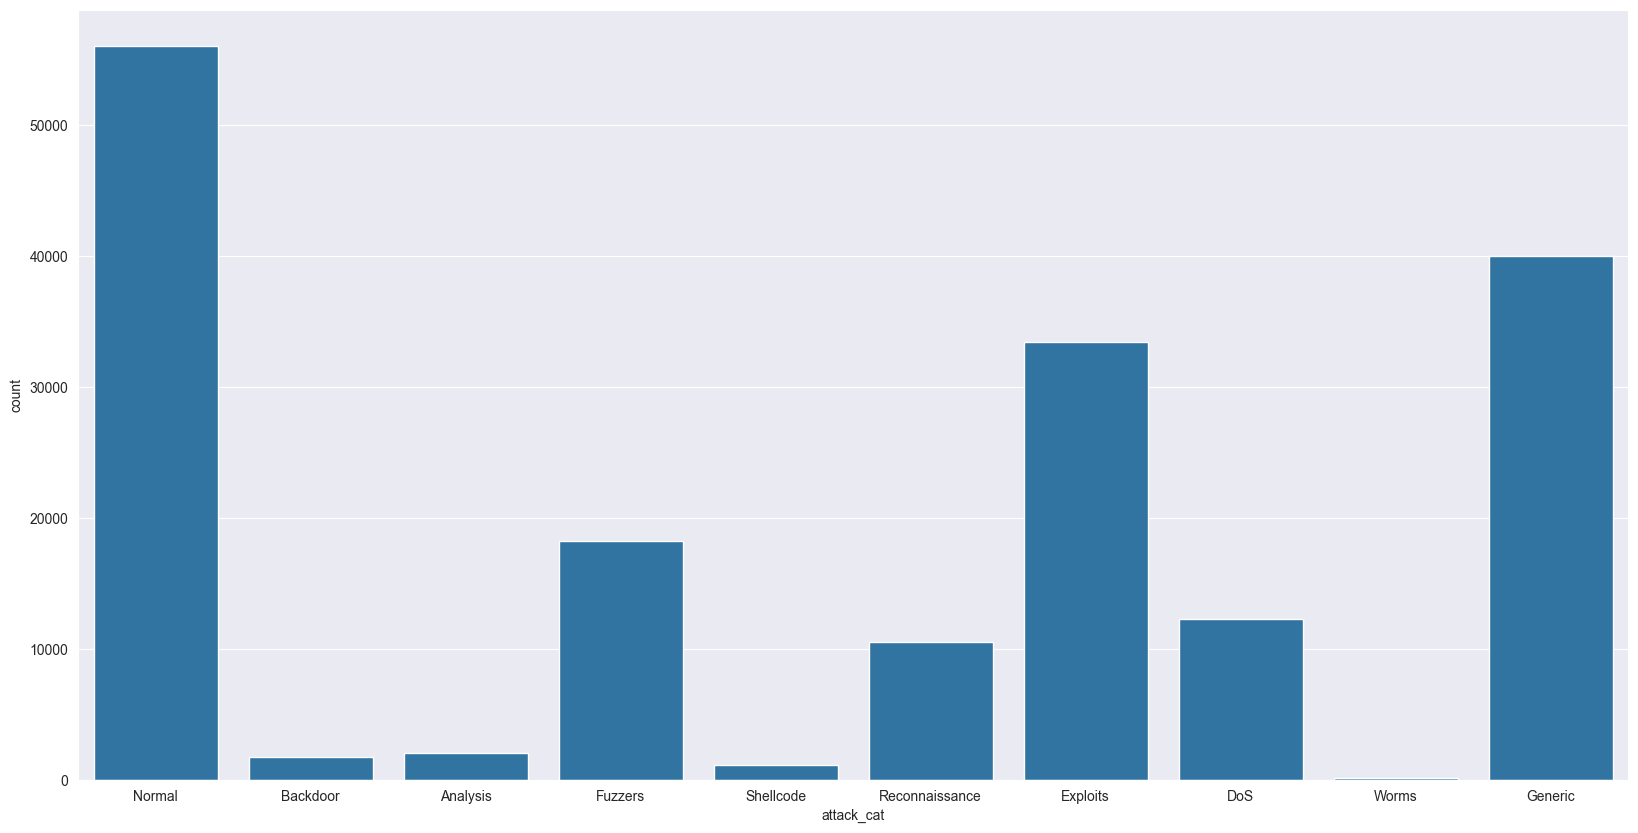

In [20]:
visualize_attack_cats(train_df)

In [21]:
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [22]:
train_df, dict_values = label_encoder_fit_col(train_df, "proto")
test_df = label_encoder_transform_col(test_df, "proto", dict_values)

In [23]:
train_df, dict_values = label_encoder_fit_col(train_df, "service")
test_df = label_encoder_transform_col(test_df, "service", dict_values)

In [24]:
train_df, dict_values = label_encoder_fit_col(train_df, "state")
test_df = label_encoder_transform_col(test_df, "state", dict_values)

In [25]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [26]:
X_train = train_df.drop(["label", "attack_cat"], axis=1)
y_train = train_df["attack_cat"]
X_test = test_df.drop(["label", "attack_cat"], axis=1)
y_test = test_df["attack_cat"]

In [27]:
X_train = min_max_scaler_fit_col(X_train)
X_test = min_max_scaler_fit_col(X_test)

In [28]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [29]:
class_weights = get_class_weights(y_train)

In [30]:
y_train, cls_label_encoder = label_encode(y_train, len(np.unique(y_train)))
y_test, _ = label_encode(y_test, len(np.unique(y_test)))

In [31]:
cls_label_encoder.classes_

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [32]:
print(y_train.shape)
print(y_test.shape)

(175341, 10)
(82332, 10)


In [33]:
print(X_train.shape)
print(X_test.shape)

(175341, 42, 1)
(82332, 42, 1)


In [34]:
from keras.layers import Dense, Dropout, BatchNormalization,SimpleRNN
from keras.models import Sequential
def create_RNN_model(input_shape,activation = 'leaky_relu',dropout_rate=0.2, num_classes=10):
    model = Sequential()
    model.add(SimpleRNN(256, input_shape=input_shape, activation=activation, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(SimpleRNN(128, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [36]:
input_shape = X_train.shape[1:]

In [62]:
from sklearn.model_selection import ParameterSampler
import tensorflow as tf
def tune_hyperparams():
    # use random serch to tune hyperparameters
    params_grid = {
        'batch_size': [32, 64, 128],
        'epochs': [10, 20, 30],
        'learning_rate': [0.0001, 0.001, 0.01],
        'dropout_rate': [0.2, 0.25, 0.3],
        'activation': ['relu', 'leaky_relu', 'tan_h'],
        'optimizer': ['adam', 'sgd', 'rmsprop']
    }
    params_list = list(ParameterSampler(params_grid, n_iter=10, random_state=42))
    best_params = None
    for params in params_list:
        print("Trying Out : ",params)
        model =  create_RNN_model(input_shape, activation=params['activation'], dropout_rate=params['dropout_rate'], num_classes=10)
        if params['optimizer'] == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        elif params['optimizer'] == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=params['learning_rate'])
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                  validation_split=0.2, class_weight=class_weights)
        _, accuracy = model.evaluate(X_test, y_test)
        if best_params is None or accuracy > best_params['accuracy']:
            best_params = {'accuracy': accuracy, 'params': params}
    print("Best Params : ", best_params)

In [ ]:
# tune_hyperparams()

In [47]:
rnn_clf = create_RNN_model(input_shape, activation='relu', dropout_rate=0.2, num_classes=10)

In [48]:
from tensorflow.keras.metrics import Recall, Precision
import tensorflow.keras as keras
rnn_clf.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', 
                 metrics=['accuracy', Precision(), Recall(), f1_score])

In [49]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_weights_file_path = "rnn_mul_clf.h5"
checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_accuracy",
                             verbose=1, save_best_only=True, mode="max", save_weights_only=True)
early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=20)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                              verbose=1, mode='max', min_delta=0.0001, cooldown=0)

call_backs = [checkpoint, early_stopping, lr_reduce]

In [42]:
rnn_clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 42, 256)           66048     
                                                                 
 dropout_4 (Dropout)         (None, 42, 256)           0         
                                                                 
 batch_normalization_4 (Bat  (None, 42, 256)           1024      
 chNormalization)                                                
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                     

In [53]:
EPOCHS = 30
BATCH_SIZE = 256
history_clf = rnn_clf.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
             validation_split=0.2, class_weight=class_weights, callbacks=call_backs)

Epoch 1/30
548/548 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.5511 - precision_2: 0.9476 - recall_2: 0.4504 - f1_score: 0.6101
Epoch 1: val_accuracy improved from 0.48271 to 0.50649, saving model to rnn_mul_clf.h5
548/548 [==============================] - 65s 118ms/step - loss: 0.2249 - accuracy: 0.5511 - precision_2: 0.9476 - recall_2: 0.4504 - f1_score: 0.6101 - val_loss: 0.1829 - val_accuracy: 0.5065 - val_precision_2: 0.9987 - val_recall_2: 0.4224 - val_f1_score: 0.5911 - lr: 0.0010
Epoch 2/30
548/548 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.5977 - precision_2: 0.8708 - recall_2: 0.4746 - f1_score: 0.6137
Epoch 2: val_accuracy did not improve from 0.50649
548/548 [==============================] - 64s 117ms/step - loss: 0.2099 - accuracy: 0.5977 - precision_2: 0.8708 - recall_2: 0.4746 - f1_score: 0.6137 - val_loss: 0.2759 - val_accuracy: 0.3278 - val_precision_2: 0.6091 - val_recall_2: 0.2828 - val_f1_score: 0.3846 - lr:

In [54]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report
def evaluate_Test(model, X_test, y_test, cls_label_encoder):
    y_hat = model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print_score(y_hat, y_true, cls_label_encoder)

In [55]:
def visualize_loss(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [56]:
def visualize_accuracy(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [57]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(model, X_test, y_test):
    y_hat = model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_hat)
    plt.figure(figsize=(20,10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=cls_label_encoder.classes_, yticklabels=cls_label_encoder.classes_)
    plt.show()
   
    

In [65]:
evaluate_Test(rnn_clf, X_test, y_test, cls_label_encoder)

2573/2573 [==============================] - 33s 13ms/step
Accuracy:  0.6106617111208279
Precision Score:  0.775620346870699
Recall Score:  0.6106617111208279
F1 Score:  0.6577447501111823
Confusion Matrix
[[   14   532     0    47    43    38     3     0     0     0]
 [   12   454     5    10    48    38     0    10     0     6]
 [  191  2610   129   617   147   148     7   122     1   117]
 [  304  2901   327  5711   312   190    21   494    10   862]
 [   40  1196   192   456  2488   646   148   652    30   214]
 [    4    97    51   359    30 18090     2   182     2    54]
 [ 2161   419   185   609  8045  2774 21310  1087    28   382]
 [   15  1110     0     9   114    19     0  2044     0   185]
 [    0   183     3    11    28     6     0   108     3    36]
 [    0     4     2     1     1     0     0     2     0    34]]


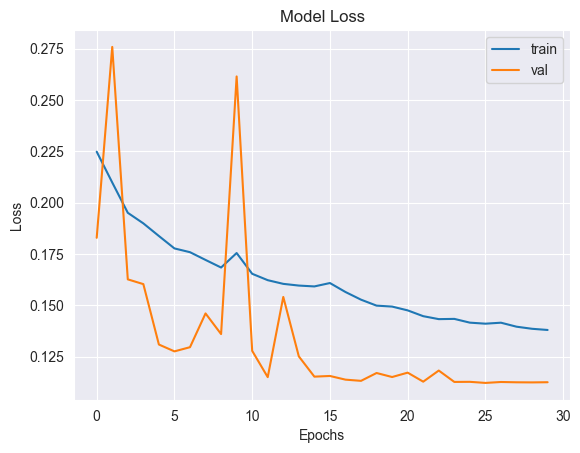

In [59]:
visualize_loss(history_clf)

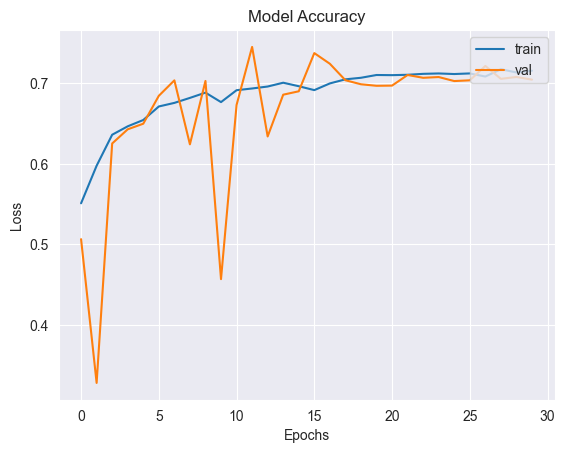

In [60]:
visualize_accuracy(history_clf)

2573/2573 [==============================] - 26s 10ms/step


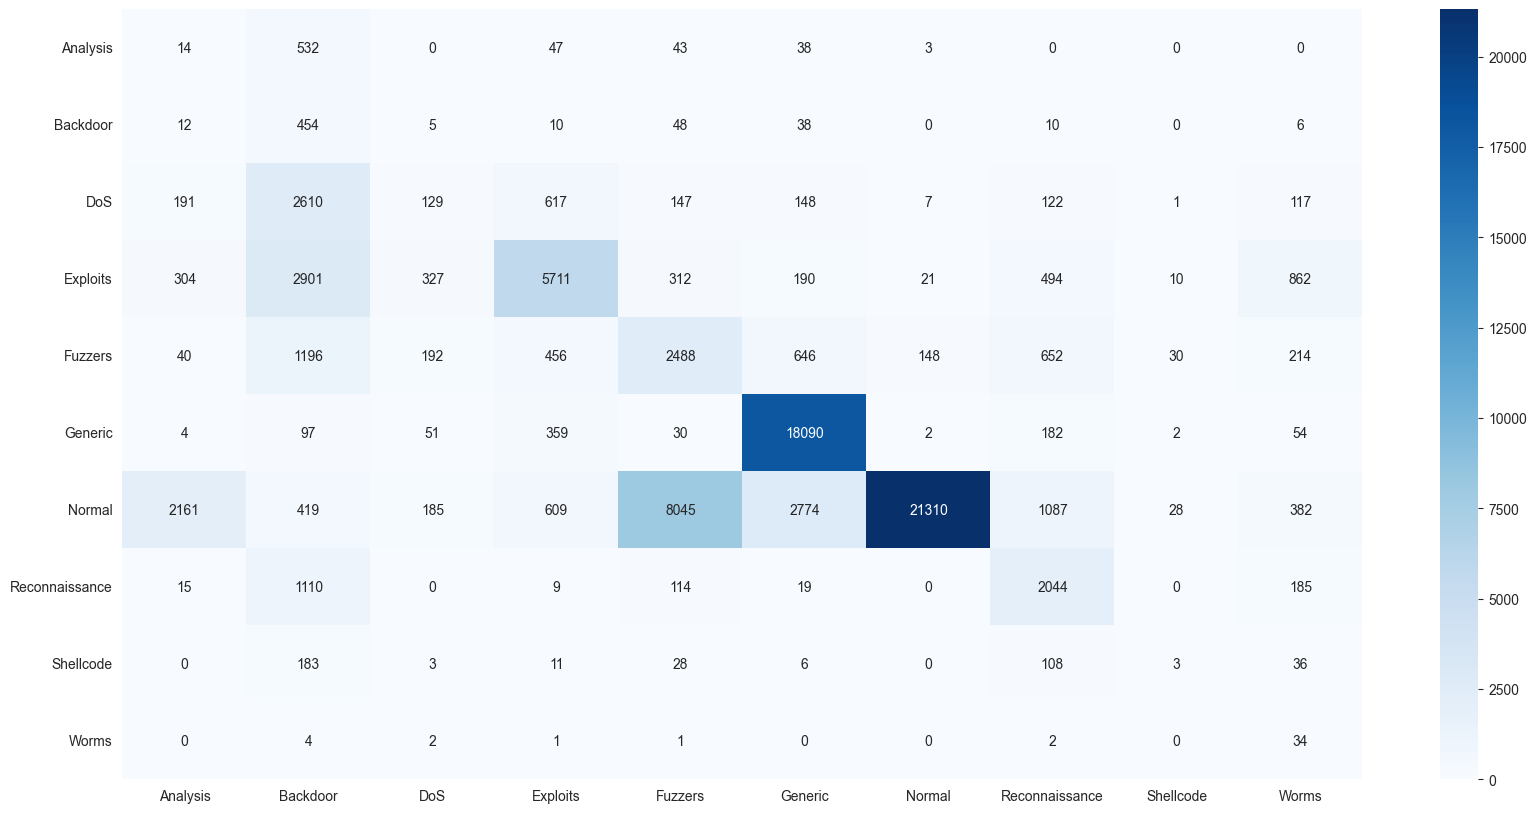

In [61]:
plot_confusion_matrix(rnn_clf, X_test, y_test)